In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import CamembertConfig, CamembertModel, AutoTokenizer, CamembertTokenizer, CamembertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import functools
from tqdm import tqdm
import gc

tqdm.pandas()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Load 20 minutes articles
# df_articles1 = pd.read_parquet('../newspaper_part1.parquet')
# df_articles2 = pd.read_parquet('../newspaper_part2.parquet')
# df_articles = pd.concat([df_articles1, df_articles2])
df_articles = pd.read_parquet('../liberation.parquet')

In [3]:
def split_text_in_parts(txt):
    """
    Split articles in part of length 500 max to be compatible with camembert model.
    """
    n = len(txt)
    prev_cursor = 0
    cursor = min(499, n-1)
    parts = []
    while prev_cursor < n-1:
        while '.' not in txt[cursor] and cursor > prev_cursor:
            cursor -= 1
        if cursor == prev_cursor:
            parts.append(txt[prev_cursor:min(prev_cursor+500, n)])
            prev_cursor = min(prev_cursor+500, n)
            cursor = min(prev_cursor+499, n-1)
        else:
            parts.append(txt[prev_cursor:cursor+1])
            prev_cursor = cursor+1
            cursor = prev_cursor+499
            if cursor >= n-1 and prev_cursor < n-1:
                parts.append(txt[prev_cursor:])
                break
    return parts


def monthly_date(url):
    if type(url[1]) == str:
        date = url[1].split("-")
        year = date[0]
        month = date[1]
    else:
        if "high-tech" in url[0]:
            date = url[0].split("-")[2]
        else:
            date = url[0].split("-")[1]
        year = date[:4]
        month = date[4:6]
    return year+"-"+month

def monthly_date_libe(url):
    if type(url[0]) == str:
        sp = url[0].split("/")
        try:
            int(sp[4]), int(sp[5])
            year = sp[4]
            month = sp[5]
        except:
            sp = url[0].split("-")[-1].split(" ")[0]
            year = sp[:4]
            month = sp[4:6]
    else:
        return None
    return year+"-"+month

In [4]:
# df_articles = pd.concat([df_articles1, df_articles2])
df_articles = df_articles[(df_articles.body != '') & (df_articles.title != '')]
df_articles["month_date"] = df_articles[["article_url", "article_date"]].progress_apply(lambda x: monthly_date_libe(x.values), axis=1)

100%|██████████| 401486/401486 [00:01<00:00, 246735.55it/s]


In [5]:
df_articles["month_date"].unique().tolist()
df_articles = df_articles[(df_articles.month_date >= "2017-01") & (df_articles.month_date < "2018-01")]

In [6]:
level = "body"

In [7]:
dataset = df_articles[[level]]

In [8]:
# Set gloabal parameters and tokenizer
MAX_LEN = 512
batch_size = 16
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [9]:
### Creation of the test dataset ###
# Creates list of texts and labels
text = dataset[level].to_list()
body_text = []
body_labels = []
body_id = []
for i in range(len(text)):
    parts = split_text_in_parts(text[i].split())
    for part in parts:
        if part != []:
            body_text.append(' '.join(part))
            body_id.append(i)

#user tokenizer to convert sentences into tokenizer
input_ids  = tokenizer(body_text, max_length=MAX_LEN, padding='longest', truncation=True).input_ids

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i!=1) for i in seq]  
    attention_masks.append(seq_mask)

In [10]:
# transfrom to tensor format
test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)

# create dataloader
test_data = TensorDataset(test_inputs, test_masks)
# test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [11]:
# Load pretained model
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=11).to(device)
model.load_state_dict(torch.load("../models/camembert_11.pt"))

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

<All keys matched successfully>

In [12]:
i = 0
with torch.no_grad():
    predic = np.ones((len(body_text), 11))
    for batch in tqdm(test_dataloader):
        t_data = batch[0].to(device)
        t_mask = batch[1].to(device)
        y = model(t_data,attention_mask=t_mask).logits
        result = y.cpu().detach().numpy()
        predic[i*batch_size:i*batch_size+len(result)] = result
        i += 1

100%|██████████| 1928/1928 [23:06<00:00,  1.39it/s]


In [13]:
from scipy.special import softmax

prob = softmax(predic, axis=1)

concat_proba_body = []
c = 0
for i in tqdm(range(max(body_id)+1)):
    proba = 0
    n = 0
    while c < len(body_id) and body_id[c] <= i:
        ni = len(input_ids[c])
        proba += ni * prob[c]
        n += ni
        c += 1
    if n > 0:
        concat_proba_body.append(proba / n)
    else:
        concat_proba_body.append(np.array([0]*11))

prob = np.array(concat_proba_body)

100%|██████████| 18154/18154 [00:00<00:00, 73433.13it/s]


In [95]:
def extract_distrib(proba):
    hist_data=list()
    group_labels = list()
    sorted_proba = np.sort(proba, axis=1)
    for i in range(11):
        hist_data.append(sorted_proba[:, i])
        group_labels.append("Group " + str(i+1))
    return hist_data, group_labels, sorted_proba

In [119]:
import plotly.express as px

hist_data, group_labels, sorted_proba = extract_distrib(prob)

df = pd.DataFrame(data=sorted_proba, columns=group_labels)
fig = px.histogram(df, x="Group 9", histfunc="count",
                   marginal="box", log_x=True)
fig.show()

In [14]:
df_articles["planete"] = prob[:, 0]
df_articles["sport"] = prob[:, 1]
df_articles["economie"] = prob[:, 2]
df_articles["arts-stars"] = prob[:, 3]
df_articles["high-tech"] = prob[:, 4]
df_articles["politique"] = prob[:, 5]
df_articles["monde"] = prob[:, 6]
df_articles["societe"] = prob[:, 7]
df_articles["faits_divers"] = prob[:, 8]
df_articles["sante"] = prob[:, 9]
df_articles["justice"] = prob[:, 10]

In [15]:
reduce_df = df_articles[["article_url", "month_date", "category_id", "planete", "sport", "economie", "arts-stars", "high-tech", "politique", 'monde', 'societe', 'faits_divers', 'sante', 'justice']]
df_streamlit = df_articles[["article_url", "month_date", "category_id", "body"]]

In [70]:
def extract_class(probabilities, th=0.05):
    cat = list()
    if probabilities[0] >= th:
        cat.append("planete")
    if probabilities[1] >= th:
        cat.append("sport")
    if probabilities[2] >= th:
        cat.append("economie")
    if probabilities[3] >= th:
        cat.append("arts-stars")
    if probabilities[4] >= th:
        cat.append("high-tech")
    if probabilities[5] >= th:
        cat.append("politique")
    if probabilities[6] >= th:
        cat.append("monde")
    if probabilities[7] >= th:
        cat.append("societe")
    if probabilities[8] >= th:
        cat.append("faits_divers")
    if probabilities[9] >= th:
        cat.append("sante")
    if probabilities[10] >= th:
        cat.append("justice")
    return " ".join(cat)

In [16]:
reduce_df.to_parquet("../data/liberation_2017.parquet")

In [127]:
len(reduce_df[(reduce_df.category_id != "environnement") & (reduce_df.planete>=0.4)]) / len(reduce_df[reduce_df.category_id=='environnement'])

1.5798319327731092

In [128]:
len(reduce_df[(reduce_df.category_id == "environnement") & (reduce_df.planete>=0.4)]) / len(reduce_df[reduce_df.category_id=='environnement'])

0.7262905162064826

<AxesSubplot: xlabel='month_date'>

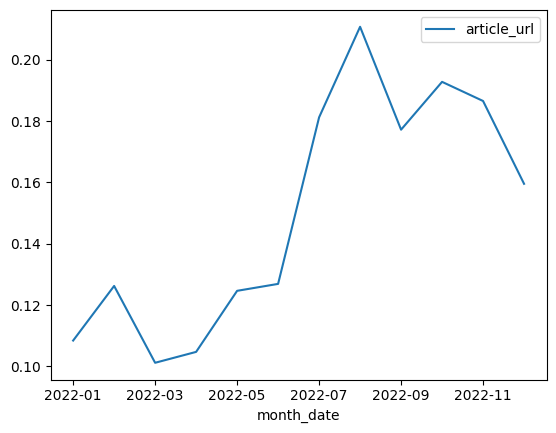

In [130]:
sorted_df = reduce_df.sort_values("month_date")
df = sorted_df[["month_date", "article_url"]][sorted_df["planete"] >= 0.2].groupby(["month_date"]).count() / (sorted_df[["month_date", "article_url"]].groupby(["month_date"]).count()+1)
df.plot()

<AxesSubplot: xlabel='month_date'>

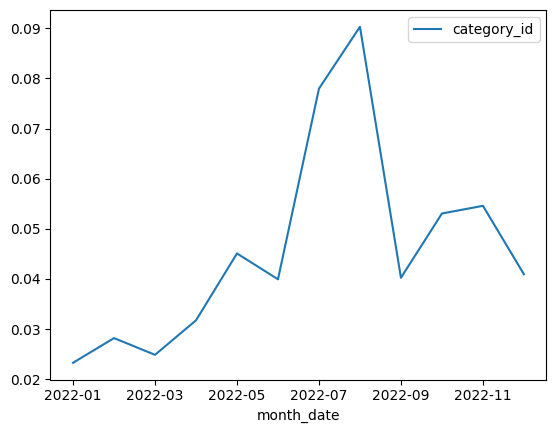

In [115]:
sorted_df = reduce_df.sort_values("month_date")
df = sorted_df[["month_date", "category_id"]][sorted_df.category_id == "environnement"].groupby(["month_date"]).count() / sorted_df[["month_date", "category_id"]].groupby(["month_date"]).count()
df.plot()

In [24]:
# df_2015 = pd.read_parquet("../data/predictions_2015_11.parquet")
# df_2016 = pd.read_parquet("../data/predictions_2016_11.parquet")
df_2017 = pd.read_parquet("../data/predictions_2017_11.parquet")
df_2018 = pd.read_parquet("../data/predictions_2018_11.parquet")
df_2019 = pd.read_parquet("../data/predictions_2019_11.parquet")
df_2020 = pd.read_parquet("../data/predictions_2020_11.parquet")
df_2021 = pd.read_parquet("../data/predictions_2021_11.parquet")
df_2022 = pd.read_parquet("../data/predictions_2022_11.parquet")

df_concat = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022])

In [25]:
df_concat.to_parquet("../data/20minutes.parquet")

<AxesSubplot: xlabel='month_date'>

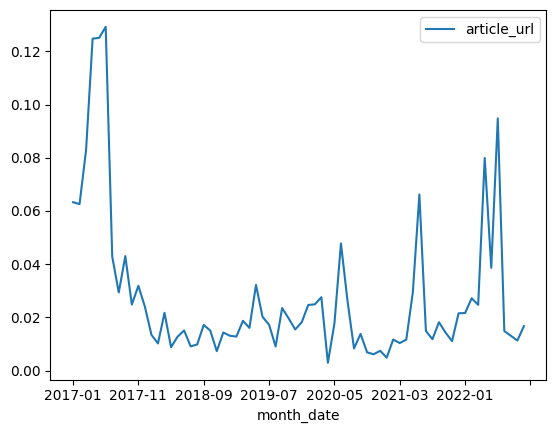

In [30]:
df = df_concat[["month_date", "article_url"]][df_concat.politique >= 0.2].groupby(["month_date"]).count() / df_concat[["month_date", "article_url"]].groupby(["month_date"]).count()
df.plot()